<a href="https://colab.research.google.com/github/jelmerbe/ORF387_Maersk_Network/blob/main/Maersk_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install networkx
!pip install basemap

In [ ]:
#install dependencies 
import numpy as np 
from pandas import read_csv
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap

Download and clean data 

In [ ]:
#import travel data 
routes_df = pd.read_csv('Maersk_data.csv', delimiter = ',')

routes_df['IMO'] = pd.to_numeric(routes_df['IMO'].astype(str), 'coerce')
routes_df['PORT_ID'] = pd.to_numeric(routes_df['PORT_ID'].astype(str), 'coerce')

#print(routes_df)
#import port data 
ports_df = pd.read_csv('port_data.csv')
#print(ports_df)


# Edges 

Create routes dataset, where each row represents a unique travel route (edge) and count of how many times this route is travelled 

In [ ]:
# Turn into numpy array 
schedule = np.genfromtxt('Maersk_data.csv', delimiter = ',')

schedule = np.column_stack([schedule[1:,0], schedule[1:,6]])
#print(schedule)

In [ ]:

#Create new array with all possible routes 
n = len(schedule[:,1])
k = 155
routes_us = np.zeros((k, 4)) # PORT1, PORT2, #ships on route, RouteID

for i in range (0,n-1): 
  if schedule[i,1] == schedule[i+1, 1]: #Check if the same ship 

    #Route already exists so increase count
    a = (schedule[i,0] * schedule[i+1, 0])/1000000

    if a in routes_us[:i,3]:  
      loc = np.where(a == routes_us[:i,3])
      routes_us[loc,2] = routes_us[loc, 2] + 1  #increase #ships on route 

    #Route does not exist so create new route  
    else: 
      routes_us[i, 0] = schedule[i, 0]      #input origin port
      routes_us[i, 1] = schedule[i+1, 0]    #input dest port 
      routes_us[i,2] = routes_us[i, 2] + 1  #increase #ships on route 
      routes_us[i,3] = (routes_us[i,0] * routes_us[i,1])/1000000 # Add routeID to data


#Print routes_us
np.set_printoptions(suppress=True) #surpress scientific notation 
print(routes_us)
 

[[31140.       30810.           5.         959.4234  ]
 [30810.       24020.           3.         740.0562  ]
 [24020.       30260.           3.         726.8452  ]
 [30260.       30810.           2.         932.3106  ]
 [30810.       30910.           2.         952.3371  ]
 [30910.       45755.           1.        1414.28705 ]
 [45755.       48050.           5.        2198.52775 ]
 [48050.       48050.          16.        2308.8025  ]
 [48050.       50017.           1.        2403.31685 ]
 [    0.           0.           0.           0.      ]
 [    0.           0.           0.           0.      ]
 [    0.           0.           0.           0.      ]
 [48050.       51587.           8.        2478.75535 ]
 [51587.       59970.           9.        3093.67239 ]
 [59970.       60250.           3.        3613.1925  ]
 [    0.           0.           0.           0.      ]
 [59970.       59940.           7.        3594.6018  ]
 [59940.       57857.           3.        3467.94858 ]
 [57857.  

In [ ]:
routes_us = routes_us[~np.all(routes_us == 0, axis = 1)]
routes_us = routes_us[~np.any(routes_us == 48050*48050/1000000, axis = 1)]
#print(routes_us)

In [ ]:
#Turn this dataset into pandas dataframe 
routes_df = pd.DataFrame(routes_us, columns = ['Origin', 'Destination', 'Number of ships', 'Route_ID'])
print(routes_df)

     Origin  Destination  Number of ships     Route_ID
0   31140.0      30810.0              5.0   959.423400
1   30810.0      24020.0              3.0   740.056200
2   24020.0      30260.0              3.0   726.845200
3   30260.0      30810.0              2.0   932.310600
4   30810.0      30910.0              2.0   952.337100
5   30910.0      45755.0              1.0  1414.287050
6   45755.0      48050.0              5.0  2198.527750
7   48050.0      50017.0              1.0  2403.316850
8   48050.0      51587.0              8.0  2478.755350
9   51587.0      59970.0              9.0  3093.672390
10  59970.0      60250.0              3.0  3613.192500
11  59970.0      59940.0              7.0  3594.601800
12  59940.0      57857.0              3.0  3467.948580
13  57857.0      51587.0              5.0  2984.669059
14  48050.0      31140.0              6.0  1496.277000
15  30910.0      31280.0              1.0   966.864800
16  31280.0      45755.0              1.0  1431.216400
17  31250.

#Nodes 
Create ports dataset, where each row represents a unique port 

In [ ]:
#Drop all unnecesary columns 
df2 = ports_df[['World Port Index Number', 'Main Port Name', 'Latitude', 'Longitude']].copy()
print(len(df2))


port_origin = routes_df.Origin.values
port_destination = routes_df.Destination.values
ports = np.concatenate((port_origin, port_destination))

#Extract ports that are used by Maersk ships
all_ports = df2 
ports_df = df2[(ports_df['World Port Index Number'].isin(ports)) ] 
print(len(ports_df))
print(len(all_ports))

3696
32
3696


#Create Network Graph Using basemap

In [53]:
 graph = nx.from_pandas_edgelist(routes_df, source = 'Origin', target = 'Destination',

                        edge_attr = 'Number of ships',create_using = nx.DiGraph())

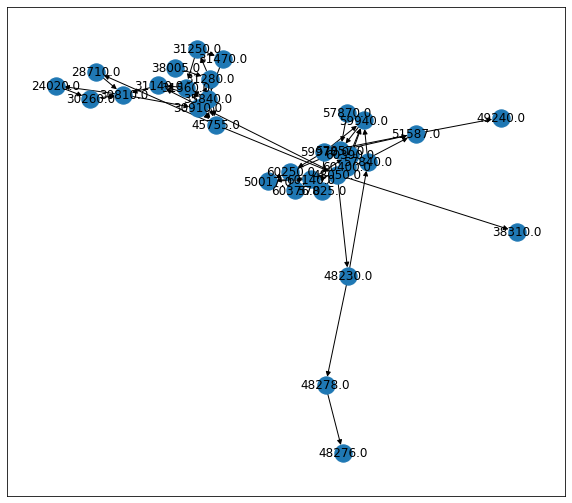

In [54]:
#Draw graph 
plt.figure(figsize = (10,9))
nx.draw_networkx(graph)
plt.show()

#Create Graph Using Basemap 

In [55]:
 plt.figure(figsize = (12,8))

 m = Basemap( projection='merc',llcrnrlat=-70,urcrnrlat=80,
             llcrnrlon=-180,urcrnrlon=180,resolution='c'  ,suppress_ticks=True)

<Figure size 864x576 with 0 Axes>

In [70]:
 mx, my = m(ports_df['Longitude'].values, ports_df['Latitude'].values)

 pos = {}

 for count, elem in enumerate (ports_df['World Port Index Number']):

     pos[elem] = (mx[count], my[count])

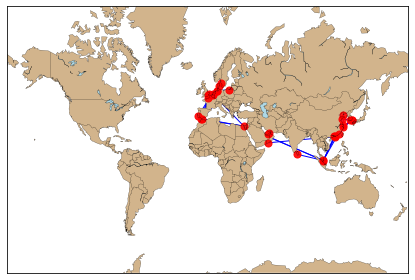

In [57]:
#Add all nodes egdes and attributes to basemap

nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = graph.nodes(), 
                        node_color = 'r', alpha = 0.9, node_size = 50)
nx.draw_networkx_edges(G = graph, pos = pos, edge_color='blue', 
                        alpha=1, arrows = False)

m.drawcountries(linewidth = 0.2)
#m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=0.2)
plt.tight_layout()
m.fillcontinents(color='tan',lake_color='lightblue')
plt.savefig(r"C:\Users\jelme\OneDrive\Documenten\Princeton\AC - Junior Year\ORF387\map1.png", format = "png", dpi = 300)
plt.show()


#Create Global Port Graph 

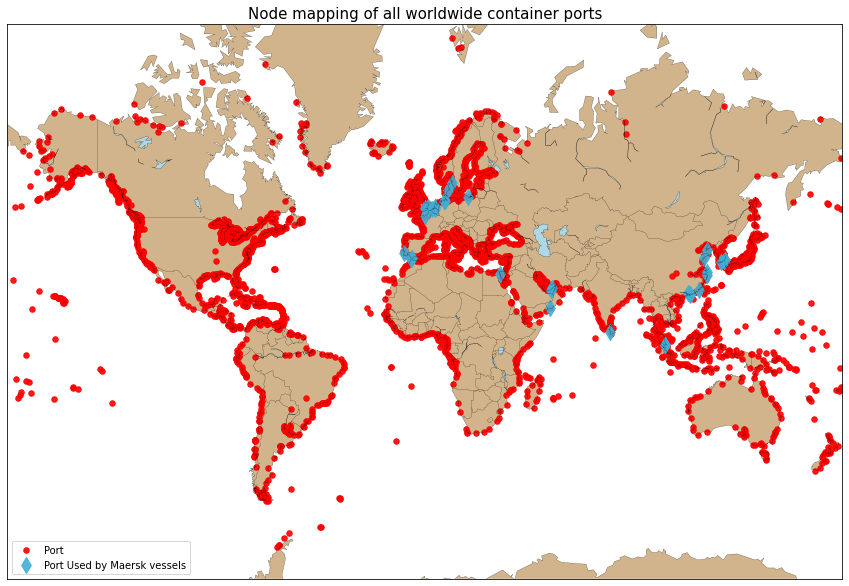

In [91]:
graph = nx.from_pandas_edgelist(all_ports, source = 'World Port Index Number',
                                target = 'World Port Index Number', 
                        create_using = nx.DiGraph())

graph2 = nx.from_pandas_edgelist(routes_df, source = 'Origin', target = 'Destination'

                        ,create_using = nx.DiGraph())
 
plt.figure(figsize = (12,8))

m = Basemap( projection='merc',llcrnrlat=-70,urcrnrlat=80,
             llcrnrlon=-180,urcrnrlon=180,resolution='c'  ,suppress_ticks=True)

#Calculate Position of ports 
mx, my = m(all_ports['Longitude'].values, all_ports['Latitude'].values)

pos_allports = {}

for count, elem in enumerate (all_ports['World Port Index Number']):

     pos_allports[elem] = (mx[count], my[count])

#Add all nodes to basemap
# Possible node shapes: so^>v<dph8.
nx.draw_networkx_nodes(G = graph, pos = pos_allports, nodelist = graph.nodes(), 
                        node_color = 'r', alpha = 0.9, node_size = 30, label = 'Port')
nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = graph2.nodes(), 
                        node_color = '#40AFD4', alpha = 0.9,node_shape = 'd', node_size = 130, label = 'Port Used by Maersk vessels')

m.drawcountries(linewidth = 0.2)
m.drawcoastlines(linewidth=0.2)
plt.tight_layout()
m.fillcontinents(color='tan',lake_color='lightblue')
plt.legend(fontsize = 10)
plt.title("Node mapping of all worldwide container ports", fontsize = 15)
plt.savefig(r"C:\Users\jelme\OneDrive\Documenten\Princeton\AC - Junior Year\ORF387\Port_map.png", format = "png", dpi = 300)
plt.show()
